In [1]:
import time
import json
from datetime import datetime, timedelta
import requests
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, LSTM, Dense

2023-10-29 20:49:30.841406: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def get_data_3_years(ticker):
    try:
        time.sleep(0.01)  
        current_date = str(datetime.today())[:10]
        three_months_ago = str(datetime.today() - timedelta(days=1095))[:10]
        URL = f'https://api.polygon.io/v2/aggs/ticker/{ticker}/range/1/day/{three_months_ago}/{current_date}?apiKey=1pgshzXCU0epjsQD1kHXC7XBc2nOcqqp'
        api_result = requests.get(url=URL)
        result_json = api_result.json()

        if 'results' in result_json:
            for i in range(len(result_json['results'])):
                unix_time = int(result_json['results'][i]['t']) / 1000
                datetime_obj = datetime.fromtimestamp(unix_time).strftime('%Y-%m-%d %H:%M:%S')
                result_json['results'][i]['t'] = datetime_obj

            return result_json
        else:
            return None
    except Exception as e:
        print(f"Error occurred for ticker {ticker}: {e}")
        return None

In [3]:
a = get_data_3_years('AAPL')

In [4]:
import pandas as pd

In [5]:
df = pd.DataFrame(a['results'])

In [6]:
df_macro = pd.DataFrame(a)

In [73]:
import matplotlib.pyplot as plt

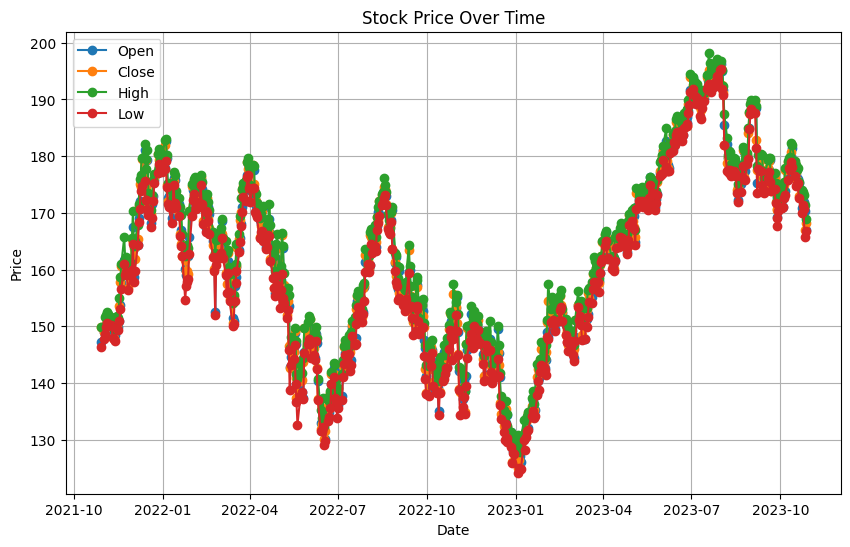

In [74]:
df['Timestamp'] = pd.to_datetime(df['t'])


plt.figure(figsize=(10, 6))
plt.plot(df['Timestamp'], df['o'], label='Open', marker='o')
plt.plot(df['Timestamp'], df['c'], label='Close', marker='o')
plt.plot(df['Timestamp'], df['h'], label='High', marker='o')
plt.plot(df['Timestamp'], df['l'], label='Low', marker='o')

plt.title('Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()

plt.show()

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [8]:
def preprocess_data(data):
        prices = [result['c'] for result in data['results']]
        prices = np.array(prices).reshape(-1, 1)
        scaled_prices = scaler.fit_transform(prices)
        return scaled_prices

In [9]:
import numpy as np

In [78]:
preprocessed = preprocess_data(df_macro)

In [100]:
def create_model():
    model = Sequential()
    model.add(GRU(64, return_sequences=True, input_shape=(1, 1)))
    model.add(LSTM(64, return_sequences=True))
    model.add(GRU(32, return_sequences=False))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [80]:
test = create_model()

In [11]:
def forecast_price_tomorrow(preprocessed_data, model):
    X = preprocessed_data[:-1]
    y = preprocessed_data[1:]

    X = X.reshape(X.shape[0], X.shape[1], 1)

    model.fit(X, y, epochs=10, batch_size=1, verbose=0)

    last_price = preprocessed_data[-1]
    last_price = last_price.reshape(1, 1, 1)

    predicted_price = model.predict(last_price)
    
    predicted_price = scaler.inverse_transform(predicted_price[0][0].reshape(-1,1))

    return predicted_price[0][0]

In [83]:
forecast_price_tomorrow(preprocessed,test)

1/1 [==============================] - 0s 481ms/step


168.49265

In [84]:
rolling = df_macro[:30]
rolling_processed = preprocess_data(rolling)
rolling_model = create_model()
tomorrow_predicted = forecast_price_tomorrow(rolling_processed, rolling_model)
tomorrow_actual = df_macro.iloc[31]['results']['c']

1/1 [==============================] - 0s 475ms/step


In [85]:
df_macro['results'][501]['t']

'2023-10-27 00:00:00'

In [86]:
tomorrow_predicted,tomorrow_actual

(181.16943, 174.33)

# Going deeper

In [91]:
master_dictionary = []

In [15]:
rolling_processed = preprocess_data(df_macro)

In [101]:
window_size = 30
rolling_model = create_model()
for start_index in range(0, len(df_macro)):
    end_index = start_index + window_size
    segment_preprocessed = preprocess_data(df_macro[start_index:end_index])
    tomorrow_predicted = forecast_price_tomorrow(rolling_processed, rolling_model)
    tomorrow_actual = df_macro.iloc[end_index+1]['results']['c']
    predicted_date = df_macro.iloc[end_index+1]['results']['t']
    
    dictionary = {
        'Prediction': tomorrow_predicted,
        'Actual': tomorrow_actual,
        'Date': predicted_date
    }
    
    master_dictionary.append(dictionary)
    print(dictionary)

1/1 [==============================] - 0s 464ms/step
{'Prediction': 167.2368, 'Actual': 174.33, 'Date': '2021-12-14 00:00:00'}
1/1 [==============================] - 0s 13ms/step
{'Prediction': 165.35555, 'Actual': 179.3, 'Date': '2021-12-15 00:00:00'}
1/1 [==============================] - 0s 13ms/step
{'Prediction': 167.2898, 'Actual': 172.26, 'Date': '2021-12-16 00:00:00'}
1/1 [==============================] - 0s 13ms/step
{'Prediction': 167.16238, 'Actual': 171.14, 'Date': '2021-12-17 00:00:00'}
1/1 [==============================] - 0s 13ms/step
{'Prediction': 167.29494, 'Actual': 169.75, 'Date': '2021-12-20 00:00:00'}
1/1 [==============================] - 0s 13ms/step
{'Prediction': 166.36061, 'Actual': 172.99, 'Date': '2021-12-21 00:00:00'}
1/1 [==============================] - 0s 13ms/step
{'Prediction': 166.36496, 'Actual': 175.64, 'Date': '2021-12-22 00:00:00'}
1/1 [==============================] - 0s 13ms/step
{'Prediction': 167.50148, 'Actual': 176.28, 'Date': '2021-12-

1/1 [==============================] - 0s 13ms/step
{'Prediction': 165.8617, 'Actual': 163.98, 'Date': '2022-03-18 00:00:00'}
1/1 [==============================] - 0s 13ms/step
{'Prediction': 166.1139, 'Actual': 165.38, 'Date': '2022-03-21 00:00:00'}
1/1 [==============================] - 0s 14ms/step
{'Prediction': 165.5394, 'Actual': 168.82, 'Date': '2022-03-22 00:00:00'}
1/1 [==============================] - 0s 13ms/step
{'Prediction': 165.6609, 'Actual': 170.21, 'Date': '2022-03-23 00:00:00'}
1/1 [==============================] - 0s 13ms/step
{'Prediction': 166.26283, 'Actual': 174.07, 'Date': '2022-03-24 00:00:00'}
1/1 [==============================] - 0s 14ms/step
{'Prediction': 165.89818, 'Actual': 174.72, 'Date': '2022-03-25 00:00:00'}
1/1 [==============================] - 0s 14ms/step
{'Prediction': 164.72804, 'Actual': 175.6, 'Date': '2022-03-28 00:00:00'}
1/1 [==============================] - 0s 14ms/step
{'Prediction': 165.025, 'Actual': 178.96, 'Date': '2022-03-29 00

1/1 [==============================] - 0s 13ms/step
{'Prediction': 146.67888, 'Actual': 135.35, 'Date': '2022-06-22 00:00:00'}
1/1 [==============================] - 0s 13ms/step
{'Prediction': 144.77235, 'Actual': 138.27, 'Date': '2022-06-23 00:00:00'}
1/1 [==============================] - 0s 13ms/step
{'Prediction': 144.62177, 'Actual': 141.66, 'Date': '2022-06-24 00:00:00'}
1/1 [==============================] - 0s 14ms/step
{'Prediction': 142.93326, 'Actual': 141.66, 'Date': '2022-06-27 00:00:00'}
1/1 [==============================] - 0s 21ms/step
{'Prediction': 142.85098, 'Actual': 137.44, 'Date': '2022-06-28 00:00:00'}
1/1 [==============================] - 0s 15ms/step
{'Prediction': 142.93584, 'Actual': 139.23, 'Date': '2022-06-29 00:00:00'}
1/1 [==============================] - 0s 27ms/step
{'Prediction': 142.62523, 'Actual': 136.72, 'Date': '2022-06-30 00:00:00'}
1/1 [==============================] - 0s 25ms/step
{'Prediction': 142.68451, 'Actual': 138.93, 'Date': '2022-0

1/1 [==============================] - 0s 19ms/step
{'Prediction': 164.80174, 'Actual': 150.43, 'Date': '2022-09-23 00:00:00'}
1/1 [==============================] - 0s 21ms/step
{'Prediction': 165.01282, 'Actual': 150.77, 'Date': '2022-09-26 00:00:00'}
1/1 [==============================] - 0s 14ms/step
{'Prediction': 165.09679, 'Actual': 151.76, 'Date': '2022-09-27 00:00:00'}
1/1 [==============================] - 0s 13ms/step
{'Prediction': 164.8658, 'Actual': 149.84, 'Date': '2022-09-28 00:00:00'}
1/1 [==============================] - 0s 16ms/step
{'Prediction': 165.05205, 'Actual': 142.48, 'Date': '2022-09-29 00:00:00'}
1/1 [==============================] - 0s 17ms/step
{'Prediction': 164.59064, 'Actual': 138.2, 'Date': '2022-09-30 00:00:00'}
1/1 [==============================] - 0s 17ms/step
{'Prediction': 161.86911, 'Actual': 142.45, 'Date': '2022-10-03 00:00:00'}
1/1 [==============================] - 0s 17ms/step
{'Prediction': 158.23393, 'Actual': 146.1, 'Date': '2022-10-0

1/1 [==============================] - 0s 15ms/step
{'Prediction': 143.6778, 'Actual': 130.03, 'Date': '2022-12-27 00:00:00'}
1/1 [==============================] - 0s 13ms/step
{'Prediction': 143.64474, 'Actual': 126.04, 'Date': '2022-12-28 00:00:00'}
1/1 [==============================] - 0s 13ms/step
{'Prediction': 142.86655, 'Actual': 129.61, 'Date': '2022-12-29 00:00:00'}
1/1 [==============================] - 0s 15ms/step
{'Prediction': 141.4513, 'Actual': 129.93, 'Date': '2022-12-30 00:00:00'}
1/1 [==============================] - 0s 13ms/step
{'Prediction': 141.26903, 'Actual': 125.07, 'Date': '2023-01-03 00:00:00'}
1/1 [==============================] - 0s 16ms/step
{'Prediction': 141.12555, 'Actual': 126.36, 'Date': '2023-01-04 00:00:00'}
1/1 [==============================] - 0s 27ms/step
{'Prediction': 140.7974, 'Actual': 125.02, 'Date': '2023-01-05 00:00:00'}
1/1 [==============================] - 0s 17ms/step
{'Prediction': 140.67497, 'Actual': 129.62, 'Date': '2023-01-0

1/1 [==============================] - 0s 30ms/step
{'Prediction': 154.74081, 'Actual': 164.9, 'Date': '2023-03-31 00:00:00'}
1/1 [==============================] - 0s 21ms/step
{'Prediction': 155.41316, 'Actual': 166.17, 'Date': '2023-04-03 00:00:00'}
1/1 [==============================] - 0s 21ms/step
{'Prediction': 157.08018, 'Actual': 165.63, 'Date': '2023-04-04 00:00:00'}
1/1 [==============================] - 0s 20ms/step
{'Prediction': 157.98535, 'Actual': 163.76, 'Date': '2023-04-05 00:00:00'}
1/1 [==============================] - 0s 19ms/step
{'Prediction': 157.76048, 'Actual': 164.66, 'Date': '2023-04-06 00:00:00'}
1/1 [==============================] - 0s 19ms/step
{'Prediction': 157.7569, 'Actual': 162.03, 'Date': '2023-04-10 00:00:00'}
1/1 [==============================] - 0s 21ms/step
{'Prediction': 158.03848, 'Actual': 160.8, 'Date': '2023-04-11 00:00:00'}
1/1 [==============================] - 0s 20ms/step
{'Prediction': 157.89673, 'Actual': 160.1, 'Date': '2023-04-12

1/1 [==============================] - 0s 20ms/step
{'Prediction': 185.04315, 'Actual': 191.81, 'Date': '2023-07-06 00:00:00'}
1/1 [==============================] - 0s 28ms/step
{'Prediction': 185.16237, 'Actual': 190.68, 'Date': '2023-07-07 00:00:00'}
1/1 [==============================] - 0s 22ms/step
{'Prediction': 184.95822, 'Actual': 188.61, 'Date': '2023-07-10 00:00:00'}
1/1 [==============================] - 0s 27ms/step
{'Prediction': 185.33592, 'Actual': 188.08, 'Date': '2023-07-11 00:00:00'}
1/1 [==============================] - 0s 20ms/step
{'Prediction': 185.62743, 'Actual': 189.77, 'Date': '2023-07-12 00:00:00'}
1/1 [==============================] - 0s 21ms/step
{'Prediction': 186.47037, 'Actual': 190.54, 'Date': '2023-07-13 00:00:00'}
1/1 [==============================] - 0s 19ms/step
{'Prediction': 187.2448, 'Actual': 190.69, 'Date': '2023-07-14 00:00:00'}
1/1 [==============================] - 0s 30ms/step
{'Prediction': 187.28316, 'Actual': 193.99, 'Date': '2023-07

1/1 [==============================] - 0s 15ms/step
{'Prediction': 182.10667, 'Actual': 177.49, 'Date': '2023-10-06 00:00:00'}
1/1 [==============================] - 0s 14ms/step
{'Prediction': 182.0096, 'Actual': 178.99, 'Date': '2023-10-09 00:00:00'}
1/1 [==============================] - 0s 14ms/step
{'Prediction': 182.07364, 'Actual': 178.39, 'Date': '2023-10-10 00:00:00'}
1/1 [==============================] - 0s 18ms/step
{'Prediction': 181.8725, 'Actual': 179.8, 'Date': '2023-10-11 00:00:00'}
1/1 [==============================] - 0s 14ms/step
{'Prediction': 181.88374, 'Actual': 180.71, 'Date': '2023-10-12 00:00:00'}
1/1 [==============================] - 0s 13ms/step
{'Prediction': 182.11026, 'Actual': 178.85, 'Date': '2023-10-13 00:00:00'}
1/1 [==============================] - 0s 13ms/step
{'Prediction': 182.0259, 'Actual': 178.72, 'Date': '2023-10-16 00:00:00'}
1/1 [==============================] - 0s 17ms/step
{'Prediction': 182.03079, 'Actual': 177.15, 'Date': '2023-10-17

IndexError: single positional indexer is out-of-bounds

In [ ]:
master_dictionary

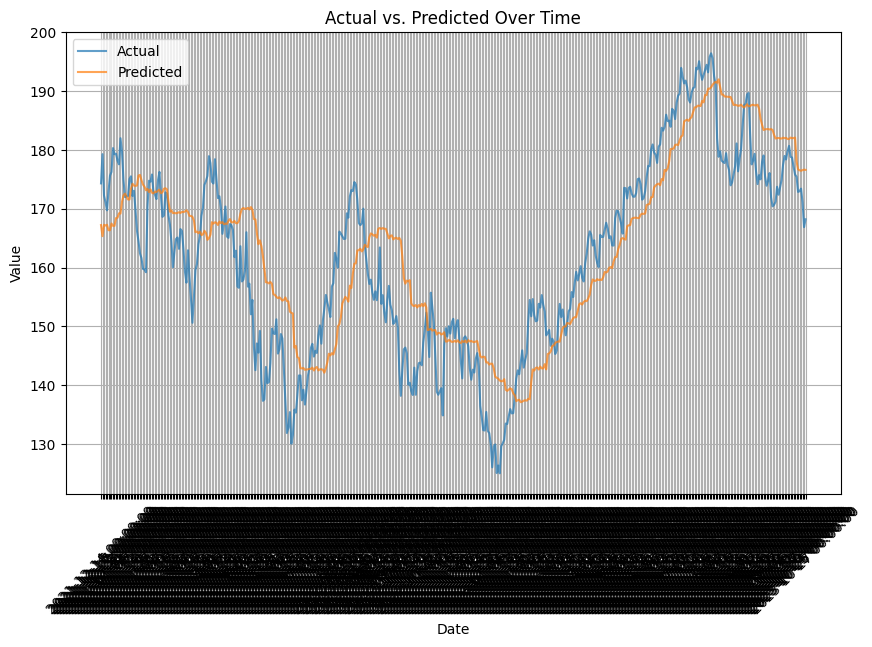

In [102]:
import seaborn as sns
import matplotlib.pyplot as plt

actual_values = [entry['Actual'] for entry in master_dictionary]
predicted_values = [entry['Prediction'] for entry in master_dictionary]
dates = [entry['Date'] for entry in master_dictionary]

plt.figure(figsize=(10, 6))
sns.lineplot(x=dates, y=actual_values, label='Actual', alpha=0.7)
sns.lineplot(x=dates, y=predicted_values, label='Predicted', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [103]:
pred_dict = pd.DataFrame(master_dictionary)

In [104]:
initial_prediction = pred_dict['Prediction'].iloc[0]

refined_predictions = [initial_prediction]

for i in range(1, len(pred_dict)):
    prediction_error = pred_dict['Actual'].iloc[i - 1] - refined_predictions[-1]

    current_prediction = refined_predictions[-1] + prediction_error

    refined_predictions.append(current_prediction)

pred_dict['Refined_Prediction'] = refined_predictions


In [106]:
pred_dict['Refined_Prediction']

0      167.236801
1      174.330000
2      179.300000
3      172.260000
4      171.140000
          ...    
466    172.880000
467    173.000000
468    173.440000
469    171.100000
470    166.890000
Name: Refined_Prediction, Length: 471, dtype: float64

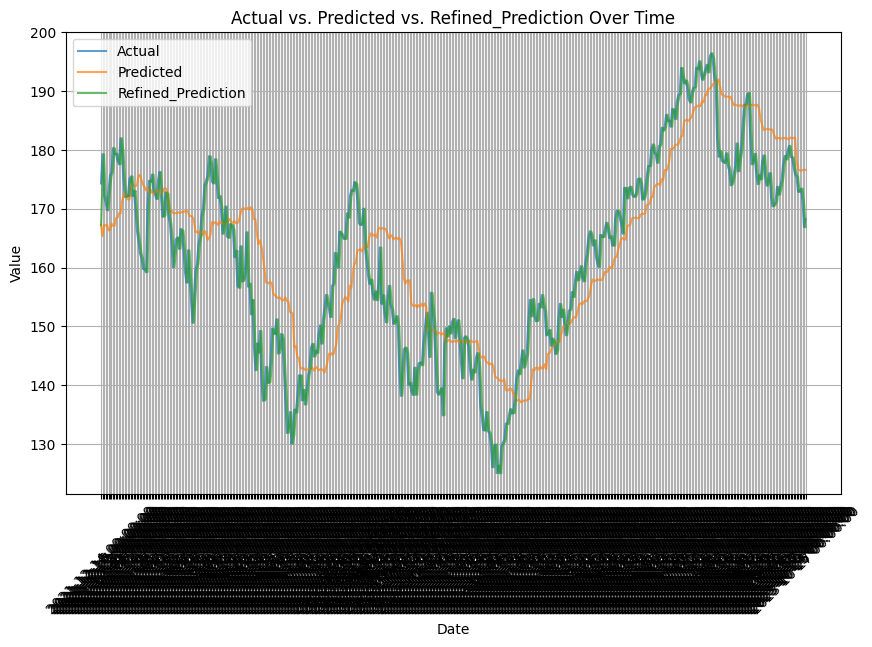

In [107]:
actual_values = pred_dict['Actual']
predicted_values = pred_dict['Prediction']
refined_predictions = pred_dict['Refined_Prediction']
dates = pred_dict['Date']


plt.figure(figsize=(10, 6))
sns.lineplot(x=dates, y=actual_values, label='Actual', alpha=0.7)
sns.lineplot(x=dates, y=predicted_values, label='Predicted', alpha=0.7)
sns.lineplot(x=dates, y=refined_predictions, label='Refined_Prediction', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs. Predicted vs. Refined_Prediction Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [115]:
pred_dict.iloc[-1]

Prediction                     176.623657
Actual                             168.22
Date                  2023-10-27 00:00:00
Refined_Prediction                 166.89
Name: 470, dtype: object

## Ensemble Learning

In [11]:
import numpy as np

In [ ]:
from sklearn

In [13]:
scaler = MinMaxScaler()

In [19]:
window_size = 30
master_dictionary = []


rolling_model = create_model()


for start_index in range(0, len(df_macro) - window_size):
    end_index = start_index + window_size
    segment_preprocessed = preprocess_data(df_macro[start_index:end_index])
    

    tomorrow_predicted = forecast_price_tomorrow(segment_preprocessed, rolling_model)
    

    tomorrow_actual = df_macro.iloc[end_index]['results']['c']
    predicted_date = df_macro.iloc[end_index]['results']['t']
    

    dictionary = {
        'Prediction': tomorrow_predicted,
        'Actual': tomorrow_actual,
        'Date': predicted_date
    }
    
    master_dictionary.append(dictionary)
    print(dictionary)
    

    updated_segment = preprocess_data(df_macro[end_index:end_index+1])
    updated_segment = updated_segment.reshape(1, 1, 1)

    tomorrow_actual = np.array([tomorrow_actual]) 
    print(updated_segment.shape)
    print(tomorrow_actual.shape)
    rolling_model.train_on_batch(updated_segment, tomorrow_actual)


1/1 [==============================] - 0s 467ms/step
{'Prediction': 188.06216, 'Actual': 175.74, 'Date': '2021-12-13 00:00:00'}
(1, 1, 1)
(1,)
1/1 [==============================] - 0s 13ms/step
{'Prediction': 172.87613, 'Actual': 174.33, 'Date': '2021-12-14 00:00:00'}
(1, 1, 1)
(1,)
1/1 [==============================] - 0s 14ms/step
{'Prediction': 167.64174, 'Actual': 179.3, 'Date': '2021-12-15 00:00:00'}
(1, 1, 1)
(1,)
1/1 [==============================] - 0s 13ms/step
{'Prediction': 166.87415, 'Actual': 172.26, 'Date': '2021-12-16 00:00:00'}
(1, 1, 1)
(1,)
1/1 [==============================] - 0s 13ms/step
{'Prediction': 166.16959, 'Actual': 171.14, 'Date': '2021-12-17 00:00:00'}
(1, 1, 1)
(1,)
1/1 [==============================] - 0s 13ms/step
{'Prediction': 165.91396, 'Actual': 169.75, 'Date': '2021-12-20 00:00:00'}
(1, 1, 1)
(1,)
1/1 [==============================] - 0s 13ms/step
{'Prediction': 166.62245, 'Actual': 172.99, 'Date': '2021-12-21 00:00:00'}
(1, 1, 1)
(1,)
1/1 [=

1/1 [==============================] - 0s 13ms/step
{'Prediction': 392.39957, 'Actual': 157.44, 'Date': '2022-03-08 00:00:00'}
(1, 1, 1)
(1,)
1/1 [==============================] - 0s 13ms/step
{'Prediction': 431.05692, 'Actual': 162.95, 'Date': '2022-03-09 00:00:00'}
(1, 1, 1)
(1,)
1/1 [==============================] - 0s 13ms/step
{'Prediction': 161.76106, 'Actual': 158.52, 'Date': '2022-03-10 00:00:00'}
(1, 1, 1)
(1,)
1/1 [==============================] - 0s 14ms/step
{'Prediction': 158.27414, 'Actual': 154.73, 'Date': '2022-03-11 00:00:00'}
(1, 1, 1)
(1,)
1/1 [==============================] - 0s 14ms/step
{'Prediction': 478.05392, 'Actual': 150.62, 'Date': '2022-03-14 00:00:00'}
(1, 1, 1)
(1,)
1/1 [==============================] - 0s 14ms/step
{'Prediction': 548.63794, 'Actual': 155.09, 'Date': '2022-03-15 00:00:00'}
(1, 1, 1)
(1,)
1/1 [==============================] - 0s 13ms/step
{'Prediction': 157.60794, 'Actual': 159.59, 'Date': '2022-03-16 00:00:00'}
(1, 1, 1)
(1,)
1/1 [=

1/1 [==============================] - 0s 13ms/step
{'Prediction': 149.21062, 'Actual': 148.84, 'Date': '2022-05-31 00:00:00'}
(1, 1, 1)
(1,)
1/1 [==============================] - 0s 14ms/step
{'Prediction': 149.20975, 'Actual': 148.71, 'Date': '2022-06-01 00:00:00'}
(1, 1, 1)
(1,)
1/1 [==============================] - 0s 14ms/step
{'Prediction': 149.11574, 'Actual': 151.21, 'Date': '2022-06-02 00:00:00'}
(1, 1, 1)
(1,)
1/1 [==============================] - 0s 13ms/step
{'Prediction': 149.01926, 'Actual': 145.38, 'Date': '2022-06-03 00:00:00'}
(1, 1, 1)
(1,)
1/1 [==============================] - 0s 13ms/step
{'Prediction': 148.55327, 'Actual': 146.14, 'Date': '2022-06-06 00:00:00'}
(1, 1, 1)
(1,)
1/1 [==============================] - 0s 13ms/step
{'Prediction': 148.46867, 'Actual': 148.71, 'Date': '2022-06-07 00:00:00'}
(1, 1, 1)
(1,)
1/1 [==============================] - 0s 13ms/step
{'Prediction': 148.54587, 'Actual': 147.96, 'Date': '2022-06-08 00:00:00'}
(1, 1, 1)
(1,)
1/1 [=

1/1 [==============================] - 0s 14ms/step
{'Prediction': 167.7454, 'Actual': 167.23, 'Date': '2022-08-23 00:00:00'}
(1, 1, 1)
(1,)
1/1 [==============================] - 0s 13ms/step
{'Prediction': 168.3534, 'Actual': 167.53, 'Date': '2022-08-24 00:00:00'}
(1, 1, 1)
(1,)
1/1 [==============================] - 0s 13ms/step
{'Prediction': 168.25616, 'Actual': 170.03, 'Date': '2022-08-25 00:00:00'}
(1, 1, 1)
(1,)
1/1 [==============================] - 0s 13ms/step
{'Prediction': 170.73608, 'Actual': 163.62, 'Date': '2022-08-26 00:00:00'}
(1, 1, 1)
(1,)
1/1 [==============================] - 0s 13ms/step
{'Prediction': 163.7574, 'Actual': 161.38, 'Date': '2022-08-29 00:00:00'}
(1, 1, 1)
(1,)
1/1 [==============================] - 0s 13ms/step
{'Prediction': 162.37401, 'Actual': 158.91, 'Date': '2022-08-30 00:00:00'}
(1, 1, 1)
(1,)
1/1 [==============================] - 0s 13ms/step
{'Prediction': 160.01392, 'Actual': 157.22, 'Date': '2022-08-31 00:00:00'}
(1, 1, 1)
(1,)
1/1 [====

1/1 [==============================] - 0s 13ms/step
{'Prediction': 147.86087, 'Actual': 148.28, 'Date': '2022-11-14 00:00:00'}
(1, 1, 1)
(1,)
1/1 [==============================] - 0s 13ms/step
{'Prediction': 147.17041, 'Actual': 150.04, 'Date': '2022-11-15 00:00:00'}
(1, 1, 1)
(1,)
1/1 [==============================] - 0s 13ms/step
{'Prediction': 148.5922, 'Actual': 148.79, 'Date': '2022-11-16 00:00:00'}
(1, 1, 1)
(1,)
1/1 [==============================] - 0s 13ms/step
{'Prediction': 147.70131, 'Actual': 150.72, 'Date': '2022-11-17 00:00:00'}
(1, 1, 1)
(1,)
1/1 [==============================] - 0s 13ms/step
{'Prediction': 149.38283, 'Actual': 151.29, 'Date': '2022-11-18 00:00:00'}
(1, 1, 1)
(1,)
1/1 [==============================] - 0s 13ms/step
{'Prediction': 150.08136, 'Actual': 148.01, 'Date': '2022-11-21 00:00:00'}
(1, 1, 1)
(1,)
1/1 [==============================] - 0s 13ms/step
{'Prediction': 147.7635, 'Actual': 150.18, 'Date': '2022-11-22 00:00:00'}
(1, 1, 1)
(1,)
1/1 [===

1/1 [==============================] - 0s 13ms/step
{'Prediction': 153.43903, 'Actual': 151.92, 'Date': '2023-02-08 00:00:00'}
(1, 1, 1)
(1,)
1/1 [==============================] - 0s 13ms/step
{'Prediction': 152.01239, 'Actual': 150.87, 'Date': '2023-02-09 00:00:00'}
(1, 1, 1)
(1,)
1/1 [==============================] - 0s 13ms/step
{'Prediction': 152.0488, 'Actual': 151.01, 'Date': '2023-02-10 00:00:00'}
(1, 1, 1)
(1,)
1/1 [==============================] - 0s 13ms/step
{'Prediction': 151.68985, 'Actual': 153.85, 'Date': '2023-02-13 00:00:00'}
(1, 1, 1)
(1,)
1/1 [==============================] - 0s 13ms/step
{'Prediction': 153.41212, 'Actual': 153.2, 'Date': '2023-02-14 00:00:00'}
(1, 1, 1)
(1,)
1/1 [==============================] - 0s 13ms/step
{'Prediction': 153.00043, 'Actual': 155.33, 'Date': '2023-02-15 00:00:00'}
(1, 1, 1)
(1,)
1/1 [==============================] - 0s 13ms/step
{'Prediction': 154.14276, 'Actual': 153.71, 'Date': '2023-02-16 00:00:00'}
(1, 1, 1)
(1,)
1/1 [===

1/1 [==============================] - 0s 13ms/step
{'Prediction': 167.84268, 'Actual': 167.45, 'Date': '2023-05-03 00:00:00'}
(1, 1, 1)
(1,)
1/1 [==============================] - 0s 13ms/step
{'Prediction': 167.05269, 'Actual': 165.79, 'Date': '2023-05-04 00:00:00'}
(1, 1, 1)
(1,)
1/1 [==============================] - 0s 13ms/step
{'Prediction': 165.72829, 'Actual': 173.57, 'Date': '2023-05-05 00:00:00'}
(1, 1, 1)
(1,)
1/1 [==============================] - 0s 14ms/step
{'Prediction': 171.41106, 'Actual': 173.5, 'Date': '2023-05-08 00:00:00'}
(1, 1, 1)
(1,)
1/1 [==============================] - 0s 13ms/step
{'Prediction': 171.426, 'Actual': 171.77, 'Date': '2023-05-09 00:00:00'}
(1, 1, 1)
(1,)
1/1 [==============================] - 0s 13ms/step
{'Prediction': 171.0641, 'Actual': 173.555, 'Date': '2023-05-10 00:00:00'}
(1, 1, 1)
(1,)
1/1 [==============================] - 0s 13ms/step
{'Prediction': 172.11453, 'Actual': 173.75, 'Date': '2023-05-11 00:00:00'}
(1, 1, 1)
(1,)
1/1 [====

1/1 [==============================] - 0s 13ms/step
{'Prediction': 192.8907, 'Actual': 193.22, 'Date': '2023-07-27 00:00:00'}
(1, 1, 1)
(1,)
1/1 [==============================] - 0s 13ms/step
{'Prediction': 192.96362, 'Actual': 195.83, 'Date': '2023-07-28 00:00:00'}
(1, 1, 1)
(1,)
1/1 [==============================] - 0s 13ms/step
{'Prediction': 193.57233, 'Actual': 196.45, 'Date': '2023-07-31 00:00:00'}
(1, 1, 1)
(1,)
1/1 [==============================] - 0s 14ms/step
{'Prediction': 194.01212, 'Actual': 195.605, 'Date': '2023-08-01 00:00:00'}
(1, 1, 1)
(1,)
1/1 [==============================] - 0s 14ms/step
{'Prediction': 194.05733, 'Actual': 192.58, 'Date': '2023-08-02 00:00:00'}
(1, 1, 1)
(1,)
1/1 [==============================] - 0s 13ms/step
{'Prediction': 193.17795, 'Actual': 191.17, 'Date': '2023-08-03 00:00:00'}
(1, 1, 1)
(1,)
1/1 [==============================] - 0s 13ms/step
{'Prediction': 191.42035, 'Actual': 181.99, 'Date': '2023-08-04 00:00:00'}
(1, 1, 1)
(1,)
1/1 [=

1/1 [==============================] - 0s 13ms/step
{'Prediction': 176.77455, 'Actual': 175.84, 'Date': '2023-10-18 00:00:00'}
(1, 1, 1)
(1,)
1/1 [==============================] - 0s 13ms/step
{'Prediction': 176.09879, 'Actual': 175.46, 'Date': '2023-10-19 00:00:00'}
(1, 1, 1)
(1,)
1/1 [==============================] - 0s 13ms/step
{'Prediction': 175.73244, 'Actual': 172.88, 'Date': '2023-10-20 00:00:00'}
(1, 1, 1)
(1,)
1/1 [==============================] - 0s 13ms/step
{'Prediction': 173.78615, 'Actual': 173, 'Date': '2023-10-23 00:00:00'}
(1, 1, 1)
(1,)
1/1 [==============================] - 0s 13ms/step
{'Prediction': 173.48027, 'Actual': 173.44, 'Date': '2023-10-24 00:00:00'}
(1, 1, 1)
(1,)
1/1 [==============================] - 0s 13ms/step
{'Prediction': 173.8052, 'Actual': 171.1, 'Date': '2023-10-25 00:00:00'}
(1, 1, 1)
(1,)
1/1 [==============================] - 0s 13ms/step
{'Prediction': 172.36221, 'Actual': 166.89, 'Date': '2023-10-26 00:00:00'}
(1, 1, 1)
(1,)
1/1 [======

In [20]:
master_dictionary

[{'Prediction': 188.06216, 'Actual': 175.74, 'Date': '2021-12-13 00:00:00'},
 {'Prediction': 172.87613, 'Actual': 174.33, 'Date': '2021-12-14 00:00:00'},
 {'Prediction': 167.64174, 'Actual': 179.3, 'Date': '2021-12-15 00:00:00'},
 {'Prediction': 166.87415, 'Actual': 172.26, 'Date': '2021-12-16 00:00:00'},
 {'Prediction': 166.16959, 'Actual': 171.14, 'Date': '2021-12-17 00:00:00'},
 {'Prediction': 165.91396, 'Actual': 169.75, 'Date': '2021-12-20 00:00:00'},
 {'Prediction': 166.62245, 'Actual': 172.99, 'Date': '2021-12-21 00:00:00'},
 {'Prediction': 165.51707, 'Actual': 175.64, 'Date': '2021-12-22 00:00:00'},
 {'Prediction': 167.34975, 'Actual': 176.28, 'Date': '2021-12-23 00:00:00'},
 {'Prediction': 173.47632, 'Actual': 180.33, 'Date': '2021-12-27 00:00:00'},
 {'Prediction': 179.29645, 'Actual': 179.29, 'Date': '2021-12-28 00:00:00'},
 {'Prediction': 178.66084, 'Actual': 179.38, 'Date': '2021-12-29 00:00:00'},
 {'Prediction': 176.90714, 'Actual': 178.2, 'Date': '2021-12-30 00:00:00'},
 

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [25]:
predictions = np.array([entry['Prediction'] for entry in master_dictionary])
actual_values = np.array([entry['Actual'] for entry in master_dictionary])


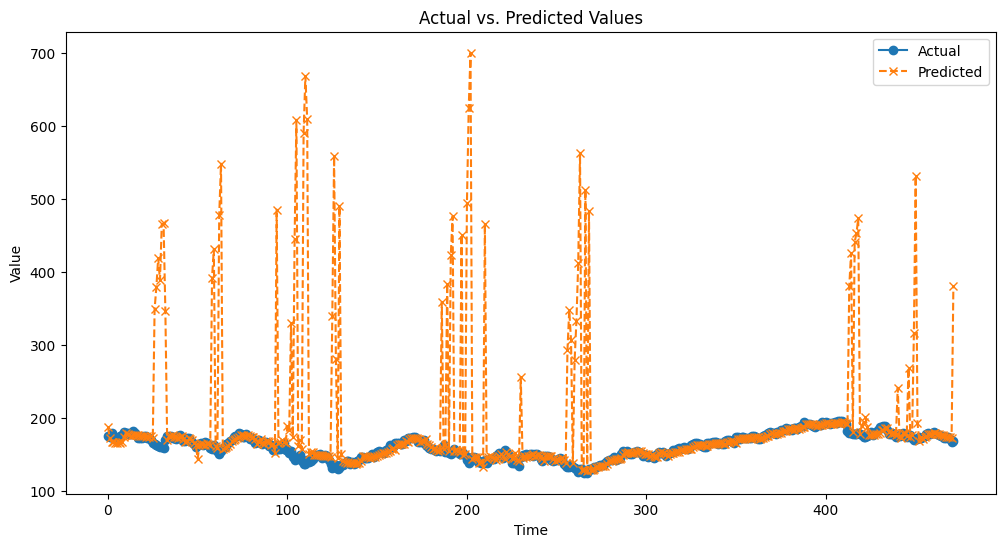

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(actual_values, label='Actual', marker='o')
plt.plot(predictions, label='Predicted', linestyle='dashed', marker='x')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Actual vs. Predicted Values')
plt.show()


In [27]:
mae = mean_absolute_error(actual_values, predictions)
mse = mean_squared_error(actual_values, predictions)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 33.52912728713731
Mean Squared Error (MSE): 10052.140620738825
Root Mean Squared Error (RMSE): 100.2603641562249


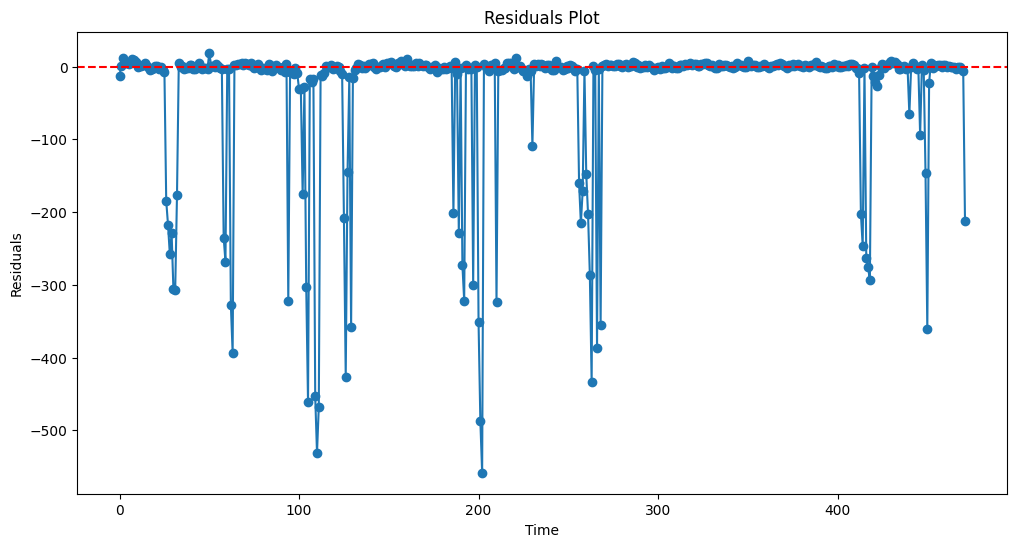

In [28]:
residuals = actual_values - predictions
plt.figure(figsize=(12, 6))
plt.plot(residuals, marker='o')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()


## Lets Ensemble 

In [29]:
window_size = 20
num_models = 3 


master_dictionary = []

rolling_models = [create_model() for _ in range(num_models)]

for start_index in range(0, len(df_macro) - window_size):
    end_index = start_index + window_size
    segment_preprocessed = preprocess_data(df_macro[start_index:end_index])
    

    model_predictions = []
    for model in rolling_models:
        tomorrow_predicted = forecast_price_tomorrow(segment_preprocessed, model)
        model_predictions.append(tomorrow_predicted)
    

    ensemble_prediction = np.mean(model_predictions) 
    

    tomorrow_actual = df_macro.iloc[end_index]['results']['c']
    predicted_date = df_macro.iloc[end_index]['results']['t']
    

    dictionary = {
        'Ensemble_Prediction': ensemble_prediction,
        'Actual': tomorrow_actual,
        'Date': predicted_date
    }
    
    master_dictionary.append(dictionary)
    
 
    updated_segment = preprocess_data(df_macro[end_index:end_index+1])
    updated_segment = updated_segment.reshape(1, 1, 1)
    tomorrow_actual = np.array([tomorrow_actual])
    
    for model in rolling_models:
        model.train_on_batch(updated_segment, tomorrow_actual)


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


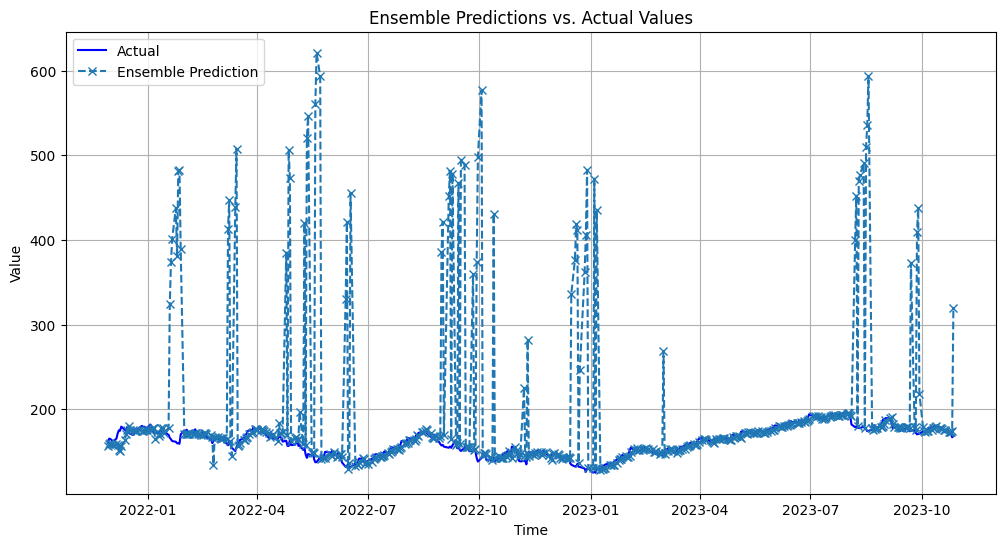

In [33]:
df = pd.DataFrame(master_dictionary)


df['Date'] = pd.to_datetime(df['Date'])


plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Actual'], label='Actual', color='blue')
plt.plot(df['Date'], df['Ensemble_Prediction'], label='Ensemble Prediction', linestyle='dashed', marker='x')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Ensemble Predictions vs. Actual Values')
plt.legend()
plt.grid(True)

plt.show()

# Lets go deeper with Ensembling

##### **Next Steps will certainly be to Set different Window Sized for Each Ensemble Model**

In [116]:
for_forest = df_macro['results']

In [117]:
for_forest = pd.DataFrame(a['results'])

In [59]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import IsolationForest


num_models = 3
window_size = 30

rolling_models = [create_model() for _ in range(num_models)]
ensemble_weights = [1.0] * num_models

min_weight = 0.1  
max_weight = 2.0  

performance_threshold = 0.8  

tolerance_threshold = 3

close_count = 0
total_count = 0

outlier_detector = IsolationForest()

outlier_detector.fit(for_forest['c'].values.reshape(-1, 1))

model_memory = [model.get_weights() for model in rolling_models]

for end_index in range(window_size, len(df_macro)):
    start_index = end_index - window_size
    segment_preprocessed = preprocess_data(df_macro[start_index:end_index])

    model_predictions = []
    for i, model in enumerate(rolling_models):
        tomorrow_predicted = forecast_price_tomorrow(segment_preprocessed, model)
        model_predictions.append(tomorrow_predicted)

        y_true = [df_macro.iloc[end_index]['results']['c']]
        y_pred = [model_predictions[i]]

        mse = mean_squared_error(y_true, y_pred)

        is_outlier = outlier_detector.predict(np.array(y_pred).reshape(-1, 1))
        
        if mse > performance_threshold or -1 in is_outlier:
            ensemble_weights[i] *= 0.9
        else:
            ensemble_weights[i] = max(ensemble_weights[i] * 1.1, min_weight)

    ensemble_prediction = np.average(model_predictions, weights=ensemble_weights)

    tomorrow_actual = df_macro.iloc[end_index]['results']['c']
    is_close = abs(ensemble_prediction - tomorrow_actual) <= tolerance_threshold

    note = "Close to Actual" if is_close else "Not Close"
    total_count += 1
    if note == "Close to Actual":
        close_count += 1

    performance = close_count / total_count

    weighted_predictions = [w * p for w, p in zip(ensemble_weights, model_predictions)]
    ensemble_prediction = sum(weighted_predictions) / sum(ensemble_weights)

    model_memory = [(1 - 0.1) * np.array(old_weight) + 0.1 * new_weight for old_weight, new_weight in zip(model_memory, ensemble_weights)]

    
    for i, model in enumerate(rolling_models):
        model.set_weights(model_memory[i])

    dictionary = {
        'Ensemble_Prediction': ensemble_prediction,
        'Actual': tomorrow_actual,
        'Date': predicted_date,
        'Note': note 
    }

    master_dictionary.append(dictionary)
    print(dictionary)



1/1 [==============================] - 0s 465ms/step
{'Ensemble_Prediction': 184.26415506998694, 'Actual': 175.74, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}


/var/folders/wd/1cybbz0x4wn4b20r_6x53pt00000gn/T/ipykernel_5954/1819450975.py:82: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  model_memory = [(1 - 0.1) * np.array(old_weight) + 0.1 * new_weight for old_weight, new_weight in zip(model_memory, ensemble_weights)]


1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 168.58588120033, 'Actual': 174.33, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 159.99796216241245, 'Actual': 179.3, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 158.95454617204337, 'Actual': 172.26, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 159.95033316776673, 'Actual': 171.14, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 160.75735578865843, 'Actual': 169.75, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 161.42705877896014, 'Actual': 172.99, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [===

1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 161.95906825351727, 'Actual': 150.62, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 160.8387362474778, 'Actual': 155.09, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 17ms/step
{'Ensemble_Prediction': 160.71538808831886, 'Actual': 159.59, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 163.47238915651312, 'Actual': 160.62, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 163.22460050713633, 'Actual': 163.98, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 165.1010053080897, 'Actual': 165.38, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [=

1/1 [==============================] - 0s 14ms/step
{'Ensemble_Prediction': 149.1953063612975, 'Actual': 142.64, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 14ms/step
{'Ensemble_Prediction': 146.5071532885612, 'Actual': 137.13, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 145.15403909638584, 'Actual': 131.88, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 142.6744044505186, 'Actual': 132.76, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 14ms/step
{'Ensemble_Prediction': 142.52351924885318, 'Actual': 135.43, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 143.09898712666572, 'Actual': 130.06, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==

1/1 [==============================] - 0s 14ms/step
{'Ensemble_Prediction': 149.1490648378172, 'Actual': 152.95, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 14ms/step
{'Ensemble_Prediction': 148.94923205372908, 'Actual': 151.6, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 148.23964140215017, 'Actual': 156.79, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 152.41228426054116, 'Actual': 157.35, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 14ms/step
{'Ensemble_Prediction': 151.9053362245454, 'Actual': 162.51, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 150.6857530436296, 'Actual': 161.51, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [===

1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 160.78169040451823, 'Actual': 155.96, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 14ms/step
{'Ensemble_Prediction': 159.3528413481033, 'Actual': 154.46, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 157.95162291066578, 'Actual': 157.37, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 160.00188682606807, 'Actual': 163.43, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 164.01507169200195, 'Actual': 153.84, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 158.40283318374037, 'Actual': 155.31, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [

1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 147.61718749999997, 'Actual': 147.81, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 14ms/step
{'Ensemble_Prediction': 147.14227294921872, 'Actual': 146.63, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 146.83035278320312, 'Actual': 142.91, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 146.0292510986328, 'Actual': 140.94, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 14ms/step
{'Ensemble_Prediction': 145.22291056315106, 'Actual': 142.65, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 145.66508992513022, 'Actual': 142.16, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [

1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 135.6126328584523, 'Actual': 135.21, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 14ms/step
{'Ensemble_Prediction': 135.08730577536028, 'Actual': 135.27, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 134.91371674165083, 'Actual': 137.87, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 135.32745072949908, 'Actual': 141.11, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 135.82988488326134, 'Actual': 142.53, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 135.96285654853426, 'Actual': 141.86, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [

1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 147.61032342927214, 'Actual': 151.03, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 149.96038152530878, 'Actual': 153.83, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 14ms/step
{'Ensemble_Prediction': 152.26283571221745, 'Actual': 151.6, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 151.37495436574656, 'Actual': 152.87, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 14ms/step
{'Ensemble_Prediction': 152.14635474258054, 'Actual': 150.59, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 14ms/step
{'Ensemble_Prediction': 150.4164636204387, 'Actual': 148.5, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==

1/1 [==============================] - 0s 14ms/step
{'Ensemble_Prediction': 173.5608039319552, 'Actual': 177.25, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 173.9318339238633, 'Actual': 180.09, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 175.13646285207454, 'Actual': 180.95, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 175.8819299340605, 'Actual': 179.58, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 14ms/step
{'Ensemble_Prediction': 176.4200980664523, 'Actual': 179.21, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 175.75607893663388, 'Actual': 177.82, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [===

1/1 [==============================] - 0s 14ms/step
{'Ensemble_Prediction': 179.04197035305555, 'Actual': 180.19, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 179.36542960651232, 'Actual': 184.12, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 180.47942871480674, 'Actual': 187.65, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 14ms/step
{'Ensemble_Prediction': 183.14380307916497, 'Actual': 187.87, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 180.5334314939271, 'Actual': 189.46, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 181.77292767076082, 'Actual': 189.7, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [=

### Different hyper tuning

In [118]:
new_dictionary = []

In [120]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import IsolationForest


num_models = 4
window_size = 10

rolling_models = [create_model() for _ in range(num_models)]
ensemble_weights = [1.0] * num_models

min_weight = 0.4  
max_weight = 1.6

performance_threshold = 0.9 

tolerance_threshold = 3

close_count = 0
total_count = 0

outlier_detector = IsolationForest()

outlier_detector.fit(for_forest['c'].values.reshape(-1, 1))

model_memory = [model.get_weights() for model in rolling_models]

for end_index in range(window_size, len(df_macro)):
    start_index = end_index - window_size
    segment_preprocessed = preprocess_data(df_macro[start_index:end_index])

    model_predictions = []
    for i, model in enumerate(rolling_models):
        tomorrow_predicted = forecast_price_tomorrow(segment_preprocessed, model)
        model_predictions.append(tomorrow_predicted)

        y_true = [df_macro.iloc[end_index]['results']['c']]
        y_pred = [model_predictions[i]]

        mse = mean_squared_error(y_true, y_pred)

        is_outlier = outlier_detector.predict(np.array(y_pred).reshape(-1, 1))
        
        if mse > performance_threshold or -1 in is_outlier:
            ensemble_weights[i] *= 0.9
        else:
            ensemble_weights[i] = max(ensemble_weights[i] * 1.1, min_weight)

    ensemble_prediction = np.average(model_predictions, weights=ensemble_weights)

    tomorrow_actual = df_macro.iloc[end_index]['results']['c']
    is_close = abs(ensemble_prediction - tomorrow_actual) <= tolerance_threshold

    note = "Close to Actual" if is_close else "Not Close"
    total_count += 1
    if note == "Close to Actual":
        close_count += 1

    performance = close_count / total_count

    weighted_predictions = [w * p for w, p in zip(ensemble_weights, model_predictions)]
    ensemble_prediction = sum(weighted_predictions) / sum(ensemble_weights)

    model_memory = [(1 - 0.1) * np.array(old_weight) + 0.1 * new_weight for old_weight, new_weight in zip(model_memory, ensemble_weights)]

    
    for i, model in enumerate(rolling_models):
        model.set_weights(model_memory[i])

    dictionary = {
        'Ensemble_Prediction': ensemble_prediction,
        'Actual': tomorrow_actual,
        'Date': predicted_date,
        'Note': note 
    }

    new_dictionary.append(dictionary)
    print(dictionary)


1/1 [==============================] - 0s 486ms/step
{'Ensemble_Prediction': 149.10709381103516, 'Actual': 149.99, 'Date': '2023-10-27 00:00:00', 'Note': 'Close to Actual'}
1/1 [==============================] - 0s 13ms/step


/var/folders/wd/1cybbz0x4wn4b20r_6x53pt00000gn/T/ipykernel_1356/2705869330.py:64: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  model_memory = [(1 - 0.1) * np.array(old_weight) + 0.1 * new_weight for old_weight, new_weight in zip(model_memory, ensemble_weights)]


1/1 [==============================] - 0s 15ms/step
{'Ensemble_Prediction': 150.03525924682617, 'Actual': 150, 'Date': '2023-10-27 00:00:00', 'Note': 'Close to Actual'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 148.9140853881836, 'Actual': 151, 'Date': '2023-10-27 00:00:00', 'Note': 'Close to Actual'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 149.1820068359375, 'Actual': 153.49, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 150.05289077758786, 'Actual': 157.87, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 151.93004608154297, 'Actual': 160.55, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 153.40238189697266, 'Actual': 161.02, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}


1/1 [==============================] - 0s 14ms/step
{'Ensemble_Prediction': 173.0067138671875, 'Actual': 172.99, 'Date': '2023-10-27 00:00:00', 'Note': 'Close to Actual'}
1/1 [==============================] - 0s 14ms/step
{'Ensemble_Prediction': 173.02089309692383, 'Actual': 175.64, 'Date': '2023-10-27 00:00:00', 'Note': 'Close to Actual'}
1/1 [==============================] - 0s 14ms/step
{'Ensemble_Prediction': 173.09439849853513, 'Actual': 176.28, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 15ms/step
{'Ensemble_Prediction': 173.0344696044922, 'Actual': 180.33, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 14ms/step
{'Ensemble_Prediction': 173.3370018005371, 'Actual': 179.29, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 173.42356491088867, 'Actual': 179.38, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Clo

1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 162.8755340576172, 'Actual': 170.33, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 162.68627166748047, 'Actual': 174.78, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 162.98621749877933, 'Actual': 174.61, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 14ms/step
{'Ensemble_Prediction': 163.04755401611328, 'Actual': 175.84, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 164.72933959960938, 'Actual': 172.9, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 166.6162223815918, 'Actual': 172.39, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==

1/1 [==============================] - 0s 14ms/step
{'Ensemble_Prediction': 162.53906476979583, 'Actual': 159.3, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 14ms/step
{'Ensemble_Prediction': 161.92101943540953, 'Actual': 157.44, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 16ms/step
{'Ensemble_Prediction': 160.8661013973403, 'Actual': 162.95, 'Date': '2023-10-27 00:00:00', 'Note': 'Close to Actual'}
1/1 [==============================] - 0s 14ms/step
{'Ensemble_Prediction': 160.84852156760996, 'Actual': 158.52, 'Date': '2023-10-27 00:00:00', 'Note': 'Close to Actual'}
1/1 [==============================] - 0s 14ms/step
{'Ensemble_Prediction': 160.65255394347477, 'Actual': 154.73, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 15ms/step
{'Ensemble_Prediction': 158.86802681588088, 'Actual': 150.62, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Cl

1/1 [==============================] - 0s 14ms/step
{'Ensemble_Prediction': 172.68321230864333, 'Actual': 165.75, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 169.77453966256476, 'Actual': 167.66, 'Date': '2023-10-27 00:00:00', 'Note': 'Close to Actual'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 169.54402494474476, 'Actual': 170.4, 'Date': '2023-10-27 00:00:00', 'Note': 'Close to Actual'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 169.5336993268659, 'Actual': 165.29, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 169.12936670806124, 'Actual': 165.07, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 168.55776693367284, 'Actual': 167.4, 'Date': '2023-10-27 00:00:00', 'Note': 'Close t

1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 149.26298141479492, 'Actual': 140.82, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 146.0942153930664, 'Actual': 137.35, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 143.7886199951172, 'Actual': 137.59, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 142.80290985107422, 'Actual': 143.11, 'Date': '2023-10-27 00:00:00', 'Note': 'Close to Actual'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 142.68667221069336, 'Actual': 140.36, 'Date': '2023-10-27 00:00:00', 'Note': 'Close to Actual'}
1/1 [==============================] - 0s 14ms/step
{'Ensemble_Prediction': 141.34363555908203, 'Actual': 140.52, 'Date': '2023-10-27 00:00:00', 'Note': 'Close 

1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 133.66990280151367, 'Actual': 141.66, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 14ms/step
{'Ensemble_Prediction': 133.98768615722656, 'Actual': 141.66, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 135.8058853149414, 'Actual': 137.44, 'Date': '2023-10-27 00:00:00', 'Note': 'Close to Actual'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 136.2135238647461, 'Actual': 139.23, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 14ms/step
{'Ensemble_Prediction': 136.78044891357422, 'Actual': 136.72, 'Date': '2023-10-27 00:00:00', 'Note': 'Close to Actual'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 137.46121215820312, 'Actual': 138.93, 'Date': '2023-10-27 00:00:00', 'Note': 'Close 

1/1 [==============================] - 0s 14ms/step
{'Ensemble_Prediction': 154.0068206787109, 'Actual': 160.01, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 15ms/step
{'Ensemble_Prediction': 155.07185745239258, 'Actual': 166.13, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 156.42780685424808, 'Actual': 165.81, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 158.49825668334964, 'Actual': 165.35, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 161.0902099609375, 'Actual': 164.87, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 162.00148010253906, 'Actual': 164.92, 'Date': '2023-10-27 00:00:00', 'Note': 'Close to Actual'}


1/1 [==============================] - 0s 16ms/step
{'Ensemble_Prediction': 158.62083053588867, 'Actual': 155.96, 'Date': '2023-10-27 00:00:00', 'Note': 'Close to Actual'}
1/1 [==============================] - 0s 18ms/step
{'Ensemble_Prediction': 158.32027053833008, 'Actual': 154.46, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 17ms/step
{'Ensemble_Prediction': 157.84104919433594, 'Actual': 157.37, 'Date': '2023-10-27 00:00:00', 'Note': 'Close to Actual'}
1/1 [==============================] - 0s 14ms/step
{'Ensemble_Prediction': 156.6968460083008, 'Actual': 163.43, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 17ms/step
{'Ensemble_Prediction': 156.81019592285156, 'Actual': 153.84, 'Date': '2023-10-27 00:00:00', 'Note': 'Close to Actual'}
1/1 [==============================] - 0s 15ms/step
{'Ensemble_Prediction': 156.38212203979492, 'Actual': 155.31, 'Date': '2023-10-27 00:00:00', 'Note': 

1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 141.37752532958984, 'Actual': 138.34, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 140.51224517822266, 'Actual': 142.99, 'Date': '2023-10-27 00:00:00', 'Note': 'Close to Actual'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 140.54988861083984, 'Actual': 138.38, 'Date': '2023-10-27 00:00:00', 'Note': 'Close to Actual'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 140.47134399414062, 'Actual': 142.41, 'Date': '2023-10-27 00:00:00', 'Note': 'Close to Actual'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 140.29837417602542, 'Actual': 143.75, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 140.18551635742188, 'Actual': 143.86, 'Date': '2023-10-27 00:00:00', 'Note':

1/1 [==============================] - 0s 14ms/step
{'Ensemble_Prediction': 143.68230357713568, 'Actual': 150.72, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 144.32787823397618, 'Actual': 151.29, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 147.79730423049008, 'Actual': 148.01, 'Date': '2023-10-27 00:00:00', 'Note': 'Close to Actual'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 145.34864762887824, 'Actual': 150.18, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 146.37868080638566, 'Actual': 151.07, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 21ms/step
{'Ensemble_Prediction': 148.90478250038026, 'Actual': 148.11, 'Date': '2023-10-27 00:00:00', 'Note': 'Close to A

1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 136.06363894534465, 'Actual': 131.86, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 135.2783289746095, 'Actual': 130.03, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 133.63360091575902, 'Actual': 126.04, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 15ms/step
{'Ensemble_Prediction': 130.48301363446802, 'Actual': 129.61, 'Date': '2023-10-27 00:00:00', 'Note': 'Close to Actual'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 129.318888887823, 'Actual': 129.93, 'Date': '2023-10-27 00:00:00', 'Note': 'Close to Actual'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 129.0283388114462, 'Actual': 125.07, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Clos

1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 142.07464495844465, 'Actual': 145.43, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 143.45828606635294, 'Actual': 150.82, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 14ms/step
{'Ensemble_Prediction': 144.2899751942174, 'Actual': 154.5, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 14ms/step
{'Ensemble_Prediction': 145.80114505215764, 'Actual': 151.73, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 146.80056375835198, 'Actual': 154.65, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 148.71280236198925, 'Actual': 151.92, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [=

1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 148.94405822939785, 'Actual': 148.5, 'Date': '2023-10-27 00:00:00', 'Note': 'Close to Actual'}
1/1 [==============================] - 0s 15ms/step
{'Ensemble_Prediction': 147.4391760152956, 'Actual': 150.47, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 147.96027827336326, 'Actual': 152.59, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 148.32976977590985, 'Actual': 152.99, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 148.92914789320346, 'Actual': 155.85, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 150.69900408725505, 'Actual': 155, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1

1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 161.99283999488466, 'Actual': 165.23, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 162.00181325276694, 'Actual': 166.47, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 14ms/step
{'Ensemble_Prediction': 162.09564862932476, 'Actual': 167.63, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 15ms/step
{'Ensemble_Prediction': 162.4086888631185, 'Actual': 166.65, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 162.4280780610584, 'Actual': 165.02, 'Date': '2023-10-27 00:00:00', 'Note': 'Close to Actual'}
1/1 [==============================] - 0s 19ms/step
{'Ensemble_Prediction': 162.45436023530507, 'Actual': 165.33, 'Date': '2023-10-27 00:00:00', 'Note': 'Close to Act

1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 172.60479736328128, 'Actual': 171.56, 'Date': '2023-10-27 00:00:00', 'Note': 'Close to Actual'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 172.50136947631836, 'Actual': 171.84, 'Date': '2023-10-27 00:00:00', 'Note': 'Close to Actual'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 172.43456649780273, 'Actual': 172.99, 'Date': '2023-10-27 00:00:00', 'Note': 'Close to Actual'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 172.5029716491699, 'Actual': 175.43, 'Date': '2023-10-27 00:00:00', 'Note': 'Close to Actual'}
1/1 [==============================] - 0s 15ms/step
{'Ensemble_Prediction': 172.67311477661133, 'Actual': 177.3, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 14ms/step
{'Ensemble_Prediction': 173.21034240722656, 'Actual': 177.25, 'Date': '2023-10-27 00:00:00', 'No

1/1 [==============================] - 0s 14ms/step
{'Ensemble_Prediction': 185.68010711669922, 'Actual': 189.59, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 186.31720733642578, 'Actual': 193.97, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 186.90890502929685, 'Actual': 192.46, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 188.19554138183594, 'Actual': 191.33, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 189.19860458374026, 'Actual': 191.81, 'Date': '2023-10-27 00:00:00', 'Note': 'Close to Actual'}
1/1 [==============================] - 0s 14ms/step
{'Ensemble_Prediction': 190.04409027099612, 'Actual': 190.68, 'Date': '2023-10-27 00:00:00', 'Note': 'Close to A

1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 193.15676116943357, 'Actual': 181.99, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 14ms/step
{'Ensemble_Prediction': 191.52676010131836, 'Actual': 178.85, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 14ms/step
{'Ensemble_Prediction': 182.75132751464844, 'Actual': 179.8, 'Date': '2023-10-27 00:00:00', 'Note': 'Close to Actual'}
1/1 [==============================] - 0s 14ms/step
{'Ensemble_Prediction': 184.70754241943357, 'Actual': 178.19, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 14ms/step
{'Ensemble_Prediction': 183.6553611755371, 'Actual': 177.97, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 14ms/step
{'Ensemble_Prediction': 180.99751663208008, 'Actual': 177.79, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}


{'Ensemble_Prediction': 180.9558563232422, 'Actual': 179.36, 'Date': '2023-10-27 00:00:00', 'Note': 'Close to Actual'}
1/1 [==============================] - 0s 14ms/step
{'Ensemble_Prediction': 180.8426170349121, 'Actual': 176.3, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 179.80112075805664, 'Actual': 174.21, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 178.10387802124023, 'Actual': 175.74, 'Date': '2023-10-27 00:00:00', 'Note': 'Close to Actual'}
1/1 [==============================] - 0s 14ms/step
{'Ensemble_Prediction': 177.84148025512695, 'Actual': 175.01, 'Date': '2023-10-27 00:00:00', 'Note': 'Close to Actual'}
1/1 [==============================] - 0s 14ms/step
{'Ensemble_Prediction': 177.56222915649417, 'Actual': 177.97, 'Date': '2023-10-27 00:00:00', 'Note': 'Close to Actual'}
1/1 [==============================

1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 175.39614868164065, 'Actual': 177.15, 'Date': '2023-10-27 00:00:00', 'Note': 'Close to Actual'}
1/1 [==============================] - 0s 14ms/step
{'Ensemble_Prediction': 176.1255950927734, 'Actual': 175.84, 'Date': '2023-10-27 00:00:00', 'Note': 'Close to Actual'}
1/1 [==============================] - 0s 17ms/step
{'Ensemble_Prediction': 176.9408302307129, 'Actual': 175.46, 'Date': '2023-10-27 00:00:00', 'Note': 'Close to Actual'}
1/1 [==============================] - 0s 14ms/step
{'Ensemble_Prediction': 177.23869323730466, 'Actual': 172.88, 'Date': '2023-10-27 00:00:00', 'Note': 'Not Close'}
1/1 [==============================] - 0s 15ms/step
{'Ensemble_Prediction': 175.65114974975583, 'Actual': 173, 'Date': '2023-10-27 00:00:00', 'Note': 'Close to Actual'}
1/1 [==============================] - 0s 13ms/step
{'Ensemble_Prediction': 175.5425148010254, 'Actual': 173.44, 'Date': '2023-10-27 00:00:00', 'Note':

In [124]:
df = pd.DataFrame(new_dictionary)
df

,Ensemble_Prediction,Actual,Date,Note
0,184.693324,175.74,2023-10-27 00:00:00,Not Close
1,168.840886,174.33,2023-10-27 00:00:00,Not Close
2,159.456319,179.30,2023-10-27 00:00:00,Not Close
3,158.830302,172.26,2023-10-27 00:00:00,Not Close
4,159.680293,171.14,2023-10-27 00:00:00,Not Close
...,...,...,...,...
503,175.651150,173.00,2023-10-27 00:00:00,Close to Actual
504,175.542515,173.44,2023-10-27 00:00:00,Close to Actual
505,175.367855,171.10,2023-10-27 00:00:00,Not Close
506,174.110924,166.89,2023-10-27 00:00:00,Not Close


#### Visualizing

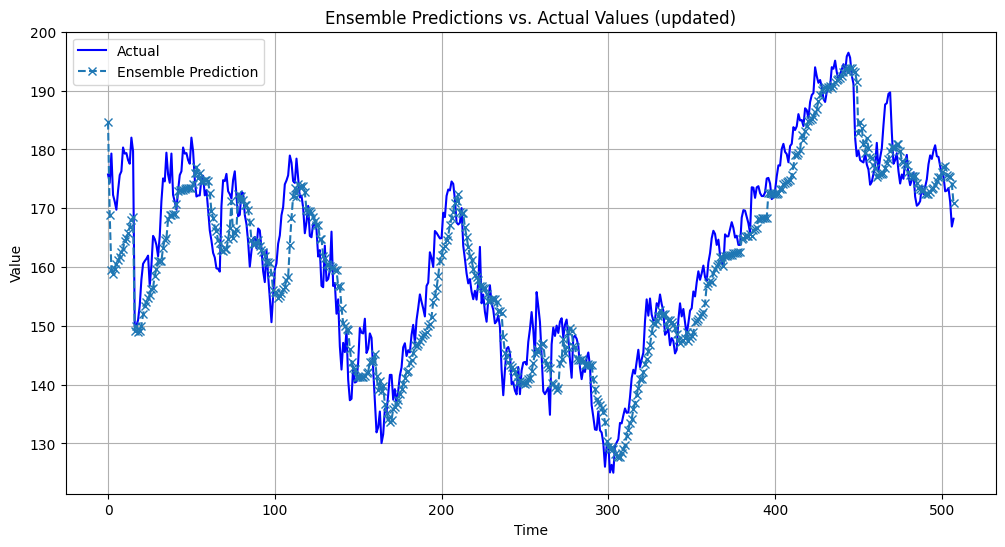

In [125]:

plt.figure(figsize=(12, 6))
plt.plot( df['Actual'], label='Actual', color='blue')
plt.plot( df['Ensemble_Prediction'], label='Ensemble Prediction', linestyle='dashed', marker='x')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Ensemble Predictions vs. Actual Values (updated)')
plt.legend()
plt.grid(True)

plt.show()

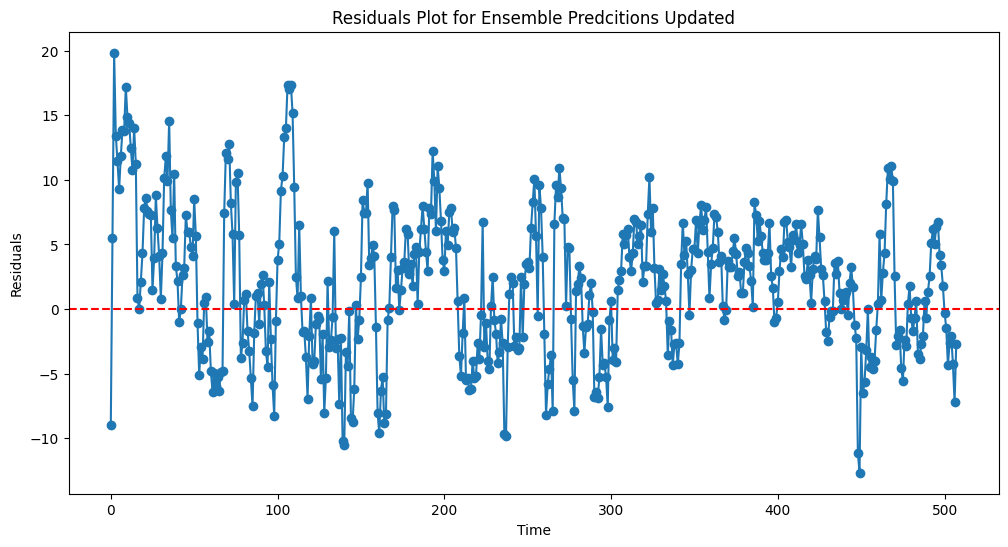

In [127]:
residuals = df['Actual'] - df['Ensemble_Prediction']
plt.figure(figsize=(12, 6))
plt.plot(residuals, marker='o')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.title('Residuals Plot for Ensemble Predcitions Updated')
plt.show()

## Stacking Model - For Proof of Concept I use GradientBoost

In [138]:
from sklearn.ensemble import GradientBoostingRegressor

base_model_predictions = np.array([entry['Ensemble_Prediction'] for entry in new_dictionary])
target_variable = np.array([entry['Actual'] for entry in new_dictionary])

model_predictions = np.array(base_model_predictions)  # Convert to a NumPy array
model_predictions = model_predictions.reshape(-1, 1)  # Reshape to a 2D array




(508, 1)

In [141]:

meta_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1)

meta_model.fit(model_predictions, target_variable)

GradientBoostingRegressor()

In [145]:
check = meta_model.predict(target_variable.reshape(-1,1))

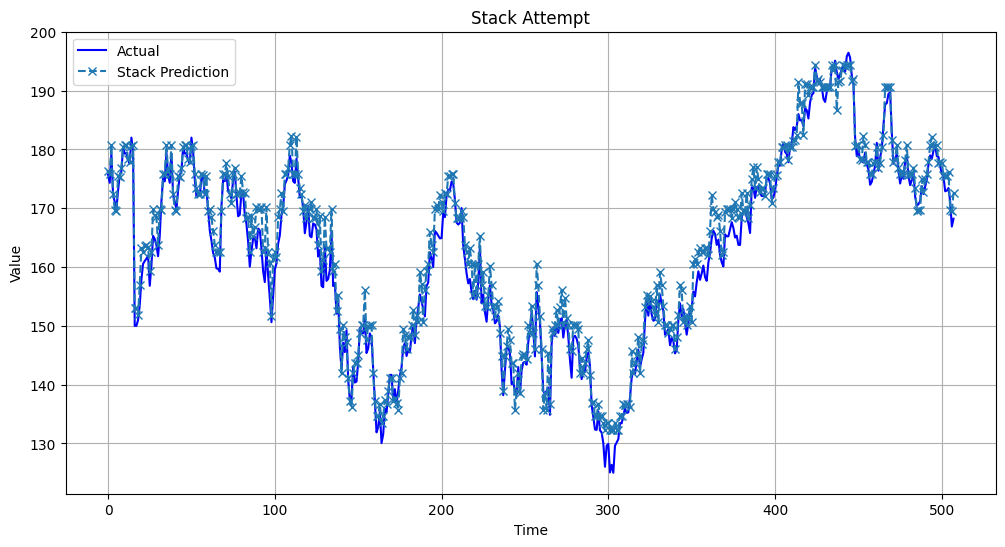

In [146]:
plt.figure(figsize=(12, 6))
plt.plot( df['Actual'], label='Actual', color='blue')
plt.plot( check, label='Stack Prediction', linestyle='dashed', marker='x')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Stack Attempt')
plt.legend()
plt.grid(True)

plt.show()

In [150]:
df['Stack']=check

In [151]:
df

,Ensemble_Prediction,Actual,Date,Note,Stack
0,184.693324,175.74,2023-10-27 00:00:00,Not Close,176.280684
1,168.840886,174.33,2023-10-27 00:00:00,Not Close,175.881381
2,159.456319,179.30,2023-10-27 00:00:00,Not Close,180.744964
3,158.830302,172.26,2023-10-27 00:00:00,Not Close,172.475245
4,159.680293,171.14,2023-10-27 00:00:00,Not Close,169.765193
...,...,...,...,...,...
503,175.651150,173.00,2023-10-27 00:00:00,Close to Actual,175.431713
504,175.542515,173.44,2023-10-27 00:00:00,Close to Actual,176.084365
505,175.367855,171.10,2023-10-27 00:00:00,Not Close,169.765193
506,174.110924,166.89,2023-10-27 00:00:00,Not Close,169.602592


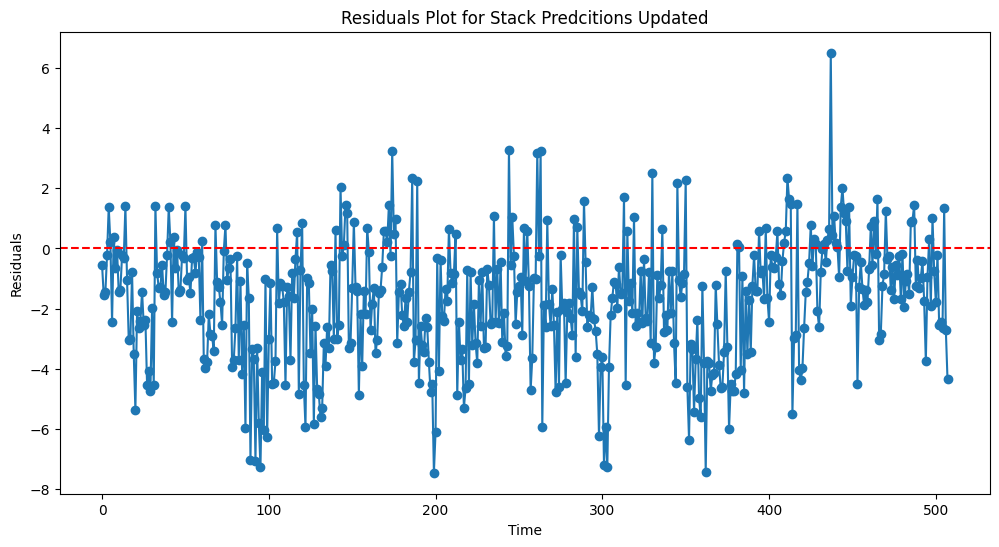

In [152]:
residuals = df['Actual'] - df['Stack']
plt.figure(figsize=(12, 6))
plt.plot(residuals, marker='o')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.title('Residuals Plot for Stack Predcitions Updated')
plt.show()